In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units

# Path to modules
sys.path.append('../modules')

# Import my modules
from constants import ucsd_colors

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
path_to_data = '/home/dnash/SEAK_clim_data/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'daily'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']

# open precipitation data
fname = path_to_out + 'SEAK_precip_max_{0}_{1}.csv'.format(option, temporal_res)
prec_df = pd.read_csv(fname)
prec_df = prec_df.replace(0, np.NaN) # replace any instance of zero with nan to ignore dates with no precipitation

# open IVT data
df_lst = []
prec_clim_lst = []
for i, community in enumerate(community_lst):
    fname = path_to_out + 'IVT_ERA5_{0}.csv'.format(community)
    ivt_df = pd.read_csv(fname)
    
    ## calculate IVT direction
    uvec = units.Quantity(ivt_df['uIVT'].values, "m/s")
    vvec = units.Quantity(ivt_df['vIVT'].values, "m/s")
    ivtdir = mpcalc.wind_direction(uvec, vvec)
    ivt_df['ivtdir'] = ivtdir
    ivt_df = ivt_df.drop(['Unnamed: 0'], axis=1) # drop unnecessary vars
    
    if temporal_res == 'hourly':
        ivt_df = ivt_df
    elif temporal_res == 'daily':
        ivt_df = ivt_df.set_index(pd.to_datetime(ivt_df['time'], format='%Y-%m-%d %H:%M:%S')) # reset the index as "date" 
        ivt_df = ivt_df.resample('1D').max()
        ivt_df = ivt_df.drop(['time'], axis=1)
        ivt_df = ivt_df.reset_index() # remove the index
    
    ## append AR data
    fname = path_to_out + 'SEAK_ardates_{0}.csv'.format(temporal_res)
    ar_df = pd.read_csv(fname) # read in AR dates

    # append AR dates to current df
    ivt_df['AR'] = ar_df.AR
    
    ## append impact data
    fname = path_to_out + 'SEAK_impactdates_{0}.csv'.format(temporal_res)
    impact_df = pd.read_csv(fname) # read in impact dates
    # append impact dates to current df
    ivt_df['impact'] = impact_df.IMPACT
    
    # ## append community precipitation data
    ivt_df['prec'] = prec_df[community]
    
    # reset the index as "time"
    ivt_df = ivt_df.set_index(pd.to_datetime(ivt_df['time']))
    
    # create day of year column
    ivt_df['day_of_year'] = ivt_df.index.dayofyear
    
    prec_clim = ivt_df.groupby(['day_of_year'])['prec'].mean()
    prec_clim_lst.append(prec_clim)
    df_lst.append(ivt_df)
    
df_lst[0]


,time,IVT,lat,lon,uIVT,vIVT,IWV,ivtdir,AR,impact,prec,day_of_year
time,,,,,,,,,,,,
1980-01-01,1980-01-01,148.93,58.00,-135.50,29.62,148.30,11.56,211.02,0,0,6.35,1
1980-01-02,1980-01-02,147.08,58.00,-135.50,6.58,146.94,11.51,186.81,0,0,10.58,2
1980-01-03,1980-01-03,101.50,58.00,-135.50,26.70,101.25,10.91,257.80,0,0,20.42,3
1980-01-04,1980-01-04,29.98,58.00,-135.50,21.53,3.76,5.02,357.52,0,0,0.19,4
1980-01-05,1980-01-05,207.19,58.00,-135.50,200.70,-24.81,10.29,343.00,1,0,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,2019-12-27,181.51,58.00,-135.50,83.21,173.45,13.28,236.71,0,1,1.05,361
2019-12-28,2019-12-28,519.33,58.00,-135.50,173.25,518.97,18.17,222.99,0,0,15.38,362
2019-12-29,2019-12-29,118.21,58.00,-135.50,43.04,117.63,10.76,208.40,0,0,NaN,363


In [40]:
# ## plot annual climatology
# prec_clim_lst[5].plot()

# number of impact days that are also ARs
a = len(df.loc[(df['impact'] == 1)])
b = len(df.loc[(df['impact'] == 1) & (df['AR'] == 1) ])
print('Out of the {0} days indicated as an impact day, {1} of them were associated with an AR'.format(a, b))

Out of the 214 days indicated as an impact day, 157 of them were associated with an AR


In [5]:
## some information on AR contribution
for i, df in enumerate(df_lst):
    print('On average in {0}...'.format(community_lst[i]))
    # number of days per year with precipitation > 0.1
    total_count = df.shape[0]
    calm_count = df.query("prec < 0.1").shape[0]
    # print('Of {} total observations, {} have less than 0.1 mm of precipitation.'.format(total_count, calm_count))
    x = (total_count - calm_count) / 40.
    print('...there are {0} days per year with precipitation greater than 0.1 mm per day'.format(x))
    # number of AR days per year
    idx = (df.AR == 1) & (df.prec > 0.1)
    tmp = df.loc[idx]
    ar_days = len(tmp) / 40.
    print('...there are {0} AR days per year'.format(ar_days))
    
    # AR contribution to total annual precipitation
    ## (total annual precip during AR days / total annual precip) * 100
    prec_clim = df.prec.groupby(df.index.year).sum() # get total precipitation per year
    ar_prec_clim = tmp.prec.groupby(tmp.index.year).sum() # get total precipitation per year during ARs
    ar_contr = (ar_prec_clim / prec_clim) *100
    avg_ar_contr = ar_contr.mean()
    print(u'...ARs contribute {:.2f}% to total annual precipitation'.format(avg_ar_contr))
    
    # number of days per year where precipitation is "extreme" > 95th percentile
    prec_thres = df['prec'].describe(percentiles=[.95]).loc['95%'] # 95th percentile precipitation threshold
    extreme_count = df.query("prec > {0}".format(prec_thres)).shape[0]
    x = extreme_count / 40.
    print(u'...there are {:.2f} days per year with precipitation greater than {:.2f} mm per day'.format(x, prec_thres))
    
    ## number of AR days with extreme precipitation
    idx = (df.AR == 1) & (df.prec > prec_thres)
    tmp = df.loc[idx]
    ar_days_extreme = len(tmp) / 40.
    print('...{0} of which are AR days'.format(ar_days_extreme))
    
    ## AR contribution to extreme precipitation
    ## (total annual precip during extreme AR days / total annual precip during extreme precip) * 100
    extreme_prec = df.loc[(df.prec > prec_thres)]
    extreme_prec_clim = extreme_prec.prec.groupby(extreme_prec.index.year).sum() # get total precipitation during extreme events
    ar_prec_clim_extreme = tmp.prec.groupby(tmp.index.year).sum() # get total precipitation per year during extreme ARs
    ar_contr = (ar_prec_clim_extreme / extreme_prec_clim) *100
    avg_ar_contr = ar_contr.mean()
    print(u'...ARs contribute {:.2f}% to extreme precipitation'.format(avg_ar_contr))

On average in Hoonah...
...there are 357.475 days per year with precipitation greater than 0.1 mm per day
...there are 112.525 AR days per year
...ARs contribute 65.11% to total annual precipitation
...there are 11.47 days per year with precipitation greater than 23.55 mm per day
...9.925 of which are AR days
...ARs contribute 86.47% to extreme precipitation
On average in Skagway...
...there are 358.85 days per year with precipitation greater than 0.1 mm per day
...there are 98.0 AR days per year
...ARs contribute 68.54% to total annual precipitation
...there are 9.45 days per year with precipitation greater than 26.76 mm per day
...8.25 of which are AR days
...ARs contribute 88.68% to extreme precipitation
On average in Klukwan...
...there are 355.5 days per year with precipitation greater than 0.1 mm per day
...there are 92.275 AR days per year
...ARs contribute 71.68% to total annual precipitation
...there are 8.85 days per year with precipitation greater than 22.34 mm per day
...7.

In [35]:
## getting bins for windrose based on percentiles
perc = [0., 0.10, 0.25, 0.5, 0.75, .95, 1.]
perc_lbl = ['0%', '10%', '25%', '50%', '75%', '95%', '100%']
final_thres = []
for i, df in enumerate(df_lst):
    sublist = []
    for j, (thres, lbl) in enumerate(zip(perc, perc_lbl)):
        sublist.append(df['prec'].describe(percentiles=[thres]).loc[[lbl]].values.tolist())
    flat_list = [item for l in sublist for item in l] # flatten the list
    # flat_list.append(np.inf)
    final_thres.append(flat_list)
final_thres

# prec_bins = [0, 2, 5, 10, 15, 20, 25, 30, 35, np.inf]

[[0.00012207031,
  0.400170894,
  1.467285175,
  4.4082031,
  10.087891,
  23.552576,
  95.7207],
 [0.0010986328,
  0.33984375,
  1.2226562,
  4.0664062,
  9.9921875,
  26.755077999999997,
  102.92578],
 [0.00024414062,
  0.217846682,
  0.8247070375,
  2.7138672,
  7.2539062,
  22.340527549999997,
  95.21484],
 [0.001953125,
  0.7000000100000001,
  2.4414062,
  7.390625,
  16.984375,
  42.110937999999976,
  178.88281],
 [0.0014648438,
  0.34375,
  1.378417925,
  4.1914062,
  9.65655525,
  23.82106889999999,
  85.9375],
 [0.0009765625,
  0.37487793,
  1.3925781000000002,
  4.4179688,
  10.1523435,
  24.9709475,
  89.953125]]

In [10]:
# 95th percentile threshold for precipitation and IVT for ALL days
prec_thres = []
ivt_thres = []
for i, df in enumerate(df_lst):
    prec_thres.append(df['prec'].describe(percentiles=[.95]))
    ivt_thres.append(df['IVT'].describe(percentiles=[.95]))
    
    df['IVT'].describe(percentiles=[.95]).loc['95%']

In [12]:
non_ar_days = []
ar_days = []
ar_extreme = []
non_ar_extreme = []

for i, df in enumerate(df_lst):
    non_ar_days.append(len(df.loc[(df['prec'] < prec_thres[i]['95%']) & (df.AR == 0)]))
    ar_days.append(len(df.loc[(df['prec'] < prec_thres[i]['95%']) & (df.AR == 1)]))
    non_ar_extreme.append(len(df.loc[(df['prec'] > prec_thres[i]['95%']) & (df.AR == 0)]))
    ar_extreme.append(len(df.loc[(df['prec'] > prec_thres[i]['95%']) & (df.AR == 1)]))
                    
d = {'Community': community_lst, 'non-AR days': non_ar_days, 'AR days': ar_days, 'Extreme non-AR days': non_ar_extreme, 'Extreme AR days': ar_extreme}
table = pd.DataFrame(data=d)

table

,Community,non-AR days,AR days,Extreme non-AR days,Extreme AR days
0,Hoonah,4492,4227,62,397
1,Skagway,3472,3707,48,330
2,Klukwan,3173,3547,41,313
3,Yakutat,4228,4250,60,387
4,Craig,4717,4004,66,393
5,Kasaan,4485,3885,106,335


### Plot IVT/Precip Scatter and IVT direction and precipitation in windrose
Use https://gist.github.com/phobson/41b41bdd157a2bcf6e14 as an example

In [36]:
## Define a function that gives nice labels for precipitation ranges

def range_labels(bins):   
    labels = []
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('<{}'.format(right))
        elif right == bins[-1]:
            labels.append('>{}'.format(left))
        else:
            labels.append('{} - {}'.format(left, right))

    return list(labels)

## Define a function to convert centered angles to left-edge radians
def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

## define wind rose function
def wind_rose(ax, rosedata, wind_dirs, legend_req, palette=None):
    if palette is None:
        palette = sns.color_palette('inferno', n_colors=rosedata.shape[1])
    else:
        palette = sns.color_palette(palette, n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)

        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)
        
    # xticks = ax.set_xticks(np.pi/180. * np.linspace(180,  -180, 8, endpoint=False))
    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    if legend_req == True:
        leg = ax.legend(loc=(0.75, 0.1), ncol=1, fontsize=12, title='Percentile')
    
    return ax

def calc_rose(df, prec_bins, prec_labels, dir_bins, dir_labels):
    '''
    ### Determine the relative percentage of observation in each speed and direction bin
    Here's how we do it:

    - assign a precipitation bin for each row with pandas.cut
    - assign a direction bin for each row (again, pandas.cut)
    - unify the 360° and 0° bins under the 0° label
    - group the data simultaneously on both precipitation and direction bins
    - compute the size of each group
    - unstack (pivot) the speed bins into columns
    - fill missing values with 0
    - assign a "calm" column to be the total number of calm observations evenly distributed across all directions
    - sort the columns -- they are a catgerical index, so "calm" will be first (this is awesome!)
    - convert all of the counts to percentages of the total number of observations
    '''
    total_count = df.shape[0]
    # if temporal_res == 'hourly':
    #     calm_thres = 0.1
    # if temporal_res == 'daily':
    #     calm_thres = 2
    calm_thres = prec_bins[0]
    calm_count = df.query("prec < {0}".format(calm_thres)).shape[0]
    print('Of {} total observations, {} have less than {} mm of precipitation.'.format(total_count, calm_count, calm_thres))
    
    df = (df.assign(prec_bins=lambda df: pd.cut(df['prec'], bins=prec_bins, labels=prec_labels, right=True))
          .assign(ivtdir_bins=lambda df: pd.cut(df['ivtdir'], bins=dir_bins, labels=dir_labels, right=False))
          .replace({'ivtdir_bins': {360: 0}})
          .groupby(by=['prec_bins', 'ivtdir_bins'])
          .size()
          .unstack(level='prec_bins')
          .fillna(0)
          # .assign(clear=lambda df: calm_count / df.shape[0])
          .sort_index(axis=1)
          .applymap(lambda x: x / total_count * 100))
        
    return df

IVT thres: 414.24 Prec thres: 23.55
IVT thres: 262.07 Prec thres: 26.76
IVT thres: 254.00 Prec thres: 22.34
IVT thres: 391.70 Prec thres: 42.11
IVT thres: 526.56 Prec thres: 23.82
IVT thres: 497.09 Prec thres: 24.97


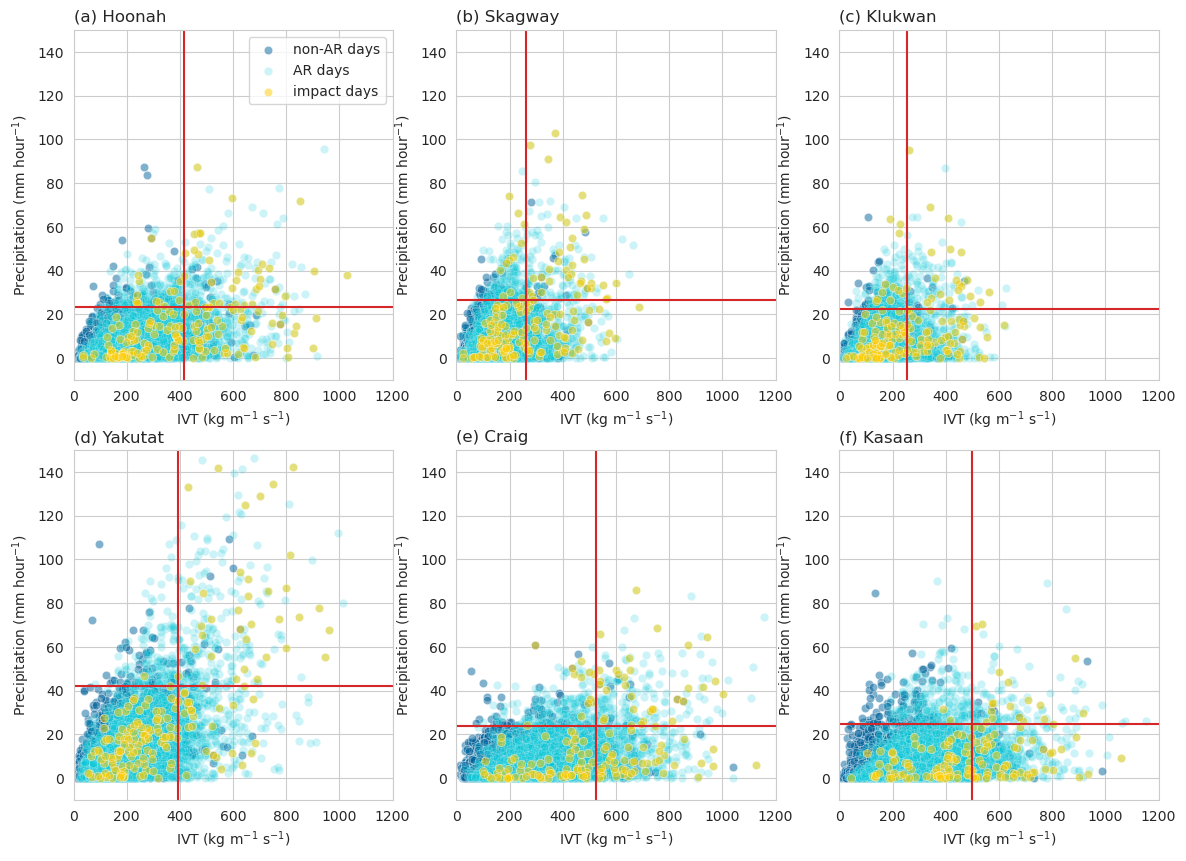

../figs/IVT-prec_scatter_daily.png


In [39]:
# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))
colors = [ucsd_colors['navy'], ucsd_colors['aqua'], ucsd_colors['yellow'], ucsd_colors['grey']]
legend_lst = [True] + [False]*5
# legend_lst = [True]*6

fname = path_to_figs + 'IVT-prec_scatter_{0}'.format(temporal_res)
fmt = 'png'
nrows = 2
ncols = 3
nplots=nrows*ncols

fig = plt.figure(figsize=(14,10))

sns.set_style("whitegrid")

for i, df in enumerate(df_lst):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ## get 95th percentile of ivt and precip
    ivt_thres = df['IVT'].describe(percentiles=[.95]).loc['95%']
    prec_thres = df['prec'].describe(percentiles=[.95]).loc['95%']
    
    # plot non-AR cases
    data = df.loc[(df.AR == 0)]
    n = len(data)
    g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[0]]), label='non-AR days'.format(n), alpha=0.5, legend=legend_lst[i])
    
    
    # plot AR cases
    data = df.loc[(df.AR == 1)]
    n = len(data)
    g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[1]]), label='AR days'.format(n), alpha=0.2, legend=legend_lst[i])
    
    
    
    print('IVT thres: {:,.2f}'.format(ivt_thres), 'Prec thres: {:,.2f}'.format(prec_thres))
    
    plt.axhline(y=prec_thres, color='tab:red', linestyle='-')
    plt.axvline(x=ivt_thres, color='tab:red', linestyle='-')
    
    ## plot Extreme AR days
    data = df.loc[(df['impact'] == 1)]
    n = len(data)
    g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[2]]), label='impact days'.format(n), alpha=0.5, legend=legend_lst[i])
    
#     ## plot Extreme non-AR days
#     data = df.loc[(df['prec'] > prec_thres) & (df.AR == 0)]
#     n = len(data)
#     g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[3]]), label='Extreme non-AR days (n={0})'.format(n), alpha=0.5, legend=legend_lst[i])
    
    
    ax.set_xlabel('IVT (kg m$^{-1}$ s$^{-1}$)')
    if temporal_res == 'hourly':
        ax.set_ylim(-.5, 25)
        ax.set_xlim(0, 1200)
        y_lbl = 'Precipitation (mm hour$^{-1}$)'
    elif temporal_res == 'daily':
        ax.set_ylim(-10, 150)
        ax.set_xlim(0, 1200)
        y_lbl = 'Precipitation (mm hour$^{-1}$)'
        
    ax.set_title('({0}) {1}'.format(letter_lst[i], community_lst[i]), loc='left')
    # ax.set_title('(n={0})'.format(n), loc='right')
    
    ax.set_ylabel(y_lbl)
    
    if legend_lst == True:
        leg = ax.legend(loc='upper left', ncol=1)
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()
fig.clf()

plotFile = fname + '.png'
print(plotFile)

Of 5981 total observations, 0 have less than 0.00012207031 mm of precipitation.
Of 5981 total observations, 0 have less than 0.0010986328 mm of precipitation.


/tmp/ipykernel_32765/997134239.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
/tmp/ipykernel_32765/997134239.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


Of 5981 total observations, 0 have less than 0.00024414062 mm of precipitation.
Of 5981 total observations, 0 have less than 0.001953125 mm of precipitation.


/tmp/ipykernel_32765/997134239.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
/tmp/ipykernel_32765/997134239.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


Of 5981 total observations, 0 have less than 0.0014648438 mm of precipitation.


/tmp/ipykernel_32765/997134239.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


Of 5981 total observations, 0 have less than 0.0009765625 mm of precipitation.


/tmp/ipykernel_32765/997134239.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


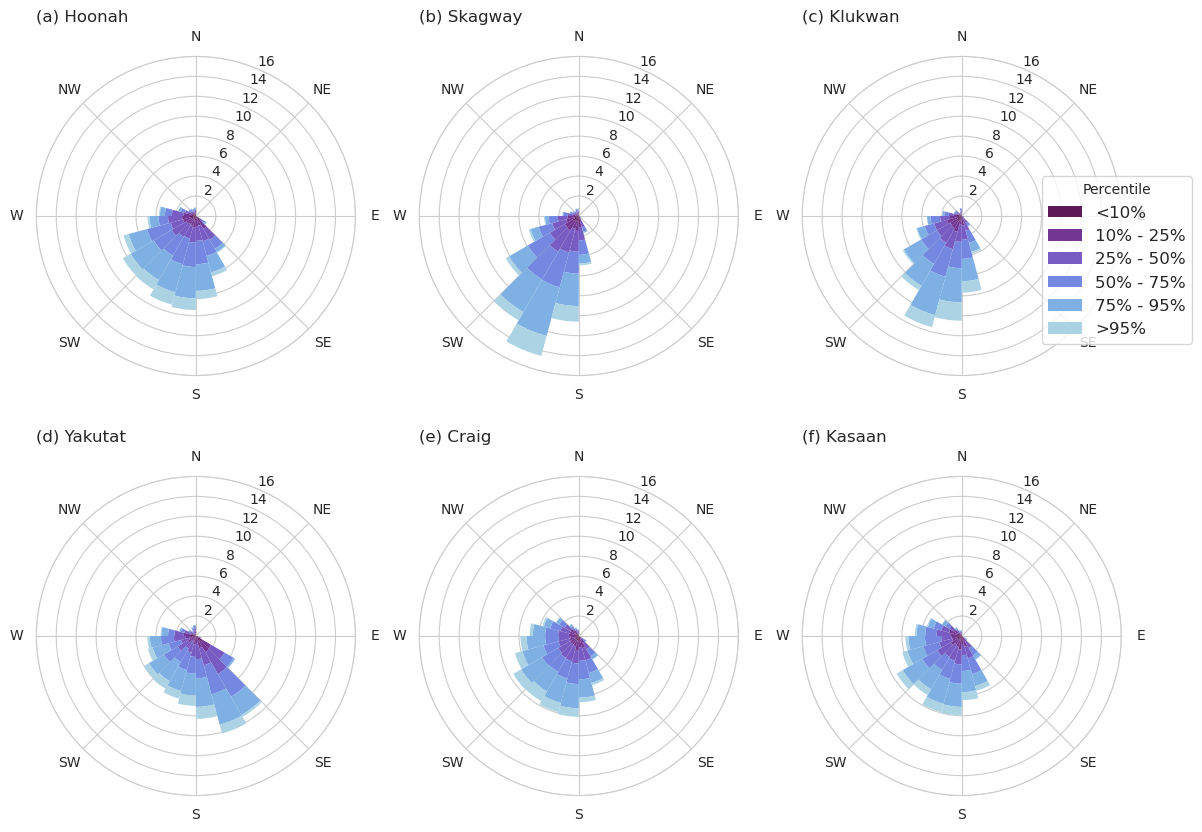

../figs/windrose_daily.png


In [38]:
## update plot so that it is 3 columns (ar type) by 1 rows (location of precip)
fname = path_to_figs + 'windrose_{0}'.format(temporal_res)
fmt = 'png'
nrows = 2
temporal_ress = 3
nplots=nrows*ncols

fig = plt.figure(figsize=(14,10))

sns.set_style("whitegrid")

#####################
### PLOT WINDROSE ###
#####################

## Define our bins and labels for speed and wind
if temporal_res == 'hourly':
    # prec_bins = [0, 0.01, 0.05, 0.25, 0.5, 0.75, 1, 2, 3, np.inf]
    rad_ticks = [1, 2, 3, 4, 5, 6]
elif temporal_res == 'daily':
    # prec_bins = [0, 2, 5, 10, 15, 20, 25, 30, 35, np.inf]
    rad_ticks = [2, 4, 6, 8, 10, 12, 14, 16]


dir_bins = np.arange(-7.5, 370, 15)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2

## use wind rose function
directions = np.arange(0, 360, 15)
legend_req = [False, False, True] + [False]*3

## loop through each AR type to plot wind rose
for i, df in enumerate(df_lst):
    prec_bins = final_thres[i]
    prec_labels = range_labels(perc_lbl)

    ax = fig.add_subplot(nrows, ncols, i+1, projection='polar')
    
    # plot AR cases
    data = df.loc[(df.AR == 1)]
    rose = calc_rose(data, prec_bins, prec_labels, dir_bins, dir_labels)
    
    ax = wind_rose(ax, rose, directions, legend_req[i], palette="cmo.dense_r")
    
    ax.set_rticks(rad_ticks)  # Less radial ticks
    ax.set_title('({0}) {1}'.format(letter_lst[i], community_lst[i]), loc='left')

# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()
fig.clf()

plotFile = fname + '.png'
print(plotFile)